In [40]:
# Cell 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, models
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

In [41]:
# Cell 2: Constants and Directory Creation
DATA_DIR = "data/Specific_test_2"
MODEL_SAVE_PATH = "models/lens_finder_model.pth"
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the 'models' directory if it doesn't exist
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

In [42]:
# Cell 3: Device Check
print(f"Using device: {DEVICE}")

Using device: cuda


In [43]:
# Cell 4: Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [44]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# Set the correct DATA_DIR path
DATA_DIR = "/teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2"

# Check if directory exists
if not os.path.exists(DATA_DIR):
    print(f"ERROR: Data directory '{DATA_DIR}' does not exist. Please check the path.")
    raise ValueError(f"Data directory not found: {DATA_DIR}")
else:
    print(f"Data directory found: {DATA_DIR}")

# Constants
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "best_lens_classifier.pth"

# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset Class
class LensDataset(Dataset):
    """
    A custom dataset for loading lens and non-lens images.

    Args:
        class_dir (str): Path to the directory containing images for a single class
                         (e.g., data/Specific_test_2/train_nonlenses).
        transform (callable, optional): Optional transform to be applied.
    """
    def __init__(self, class_dir, transform=None):
        self.class_dir = class_dir
        self.transform = transform
        self.classes = ["nonlenses", "lenses"]  # Keep for consistency, error handling
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = self._make_dataset()
        self.error_counts = {"nonlenses": 0, "lenses": 0}  # Initialize for both

    def _make_dataset(self):
        """Creates a list of (image_path, class_index) tuples."""
        samples = []

        print(f"DEBUG: Attempting to use directory: {self.class_dir}")

        if not os.path.isdir(self.class_dir):
            print(f"Directory not found: {self.class_dir}")
            return []  # Return empty list if directory not found

        filenames = [f for f in os.listdir(self.class_dir) if f.endswith(".npy")]
        if not filenames:
            print(f"Warning: Directory {self.class_dir} is empty or contains no .npy files.")
            return [] # Return empty list if no files

        # Determine the class label from the directory name
        class_name = os.path.basename(self.class_dir).replace("train_", "").replace("test_", "")
        label = self.class_to_idx.get(class_name) # Get the label, handle errors

        if label is None:
            print(f"Warning: Unknown class directory name: {self.class_dir}")
            return []

        for filename in filenames:
            path = os.path.join(self.class_dir, filename)
            item = (path, label)
            samples.append(item)

        print(f"Found {len(samples)} samples in {self.class_dir}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image_np = np.load(img_path)

            # Normalize *EACH CHANNEL* individually:
            image_np = image_np.astype(np.float32)
            for i in range(image_np.shape[0]):
                channel = image_np[i]
                min_val = channel.min()
                max_val = channel.max()
                if max_val > min_val:
                    image_np[i] = (channel - min_val) / (max_val - min_val)
                else:
                    image_np[i] = 0

            image_np = (image_np * 255).astype(np.uint8)
            image_pil = Image.fromarray(image_np.transpose(1, 2, 0), mode='RGB')

            if self.transform:
                image = self.transform(image_pil)
            else:
                image = transforms.ToTensor()(image_pil)
            return image, label

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Increment error count based on the class of the image
            class_name = os.path.basename(self.class_dir).replace("train_", "").replace("test_", "")
            if class_name in self.error_counts:  # Check if class_name is valid
                self.error_counts[class_name] += 1
            return torch.zeros((3, 224, 224), dtype=torch.float32), label

    def report_errors(self):
        print("Data loading errors:")
        for cls_name, count in self.error_counts.items():
            print(f"  {cls_name}: {count}")

def create_dataloaders(data_dir, train_transforms, val_transforms, test_transforms, batch_size=32):
    """
    Creates data loaders for training, validation, and test sets with improved error handling.
    """
    # Create Datasets (Train and Test) - Now create for EACH class directory
    train_lenses_dir = os.path.join(data_dir, "train_lenses")
    train_nonlenses_dir = os.path.join(data_dir, "train_nonlenses")
    test_lenses_dir = os.path.join(data_dir, "test_lenses")
    test_nonlenses_dir = os.path.join(data_dir, "test_nonlenses")
    
    # Check if directories exist
    for dir_path in [train_lenses_dir, train_nonlenses_dir, test_lenses_dir, test_nonlenses_dir]:
        if not os.path.exists(dir_path):
            print(f"WARNING: Directory '{dir_path}' does not exist!")
    
    train_lenses_dataset = LensDataset(class_dir=train_lenses_dir, transform=train_transforms)
    train_nonlenses_dataset = LensDataset(class_dir=train_nonlenses_dir, transform=train_transforms)
    test_lenses_dataset = LensDataset(class_dir=test_lenses_dir, transform=test_transforms)
    test_nonlenses_dataset = LensDataset(class_dir=test_nonlenses_dir, transform=test_transforms)
    
    # Check for empty datasets
    if len(train_lenses_dataset) == 0:
        print(f"WARNING: No lens samples found in {train_lenses_dir}")
    if len(train_nonlenses_dataset) == 0:
        print(f"WARNING: No non-lens samples found in {train_nonlenses_dir}")
    
    # If all datasets are empty, we can't proceed
    if (len(train_lenses_dataset) == 0 and len(train_nonlenses_dataset) == 0 and
        len(test_lenses_dataset) == 0 and len(test_nonlenses_dataset) == 0):
        raise ValueError(f"No data found in any directories. Please check {data_dir} and subdirectories.")
    
    # Combine datasets (handling empty datasets)
    train_datasets = []
    if len(train_lenses_dataset) > 0:
        train_datasets.append(train_lenses_dataset)
    if len(train_nonlenses_dataset) > 0:
        train_datasets.append(train_nonlenses_dataset)
    
    if not train_datasets:
        raise ValueError(f"No training data found. Please check {train_lenses_dir} and {train_nonlenses_dir}")
        
    train_dataset = torch.utils.data.ConcatDataset(train_datasets)
    
    # Handle test datasets similarly
    test_datasets = []
    if len(test_lenses_dataset) > 0:
        test_datasets.append(test_lenses_dataset)
    if len(test_nonlenses_dataset) > 0:
        test_datasets.append(test_nonlenses_dataset)
    
    if not test_datasets:
        print(f"WARNING: No test data found. Test loader will not be created.")
        test_dataset = None
    else:
        test_dataset = torch.utils.data.ConcatDataset(test_datasets)

    # Split into train and validation sets
    if len(train_dataset) == 0:
        raise ValueError("Cannot create train/val split: training dataset is empty")
    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    
    if train_size == 0 or val_size == 0:
        raise ValueError(f"Train/val split resulted in empty dataset: train_size={train_size}, val_size={val_size}")
    
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # --- Debugging Prints ---
    print(f"Length of train_dataset: {len(train_dataset)}")
    print(f"Length of val_dataset: {len(val_dataset)}")
    print(f"Length of test_dataset: {0 if test_dataset is None else len(test_dataset)}")

    # Handle label printing safely
    if len(train_dataset) > 0:
        print("First few labels of train_dataset:", [train_dataset[i][1] for i in range(min(10, len(train_dataset)))])
    if len(val_dataset) > 0:
        print("First few labels of val_dataset:", [val_dataset[i][1] for i in range(min(10, len(val_dataset)))])
    if test_dataset is not None and len(test_dataset) > 0:
        print("First few labels of test_dataset:", [test_dataset[i][1] for i in range(min(10, len(test_dataset)))])
    # --- End Debugging Prints ---

    # --- Handle Class Imbalance (WeightedRandomSampler) ---
    class_counts = [0, 0]
    for _, label in train_dataset:
        class_counts[label] += 1
    print(f"Class counts in training set: {class_counts}")

    if class_counts[0] == 0 or class_counts[1] == 0:
        raise ValueError(
            "One or more classes have no samples in the training set after splitting. Check your data and split ratio."
        )

    weights = [1.0 / max(1, count) for count in class_counts]  # Avoid division by zero
    sample_weights = [weights[label] for _, label in train_dataset]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    test_loader = None
    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

Data directory found: /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2


In [45]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),  # 224 / 2 / 2 = 56
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# Option 2: ResNet18 (pre-trained) - Commented out but available if needed
"""
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 1)  # Binary classification

    def forward(self, x):
        return self.model(x)
"""

# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device):
    """Trains the model and saves the best weights based on validation AUC."""
    best_val_auc = 0.0
    train_losses = []
    val_losses = []
    train_auc_scores = []
    val_auc_scores = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Sigmoid for AUC
            all_preds.extend(preds)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_auc = roc_auc_score(all_labels, all_preds)
        print(f'  Train Loss: {epoch_loss:.4f}  Train AUC: {train_auc:.4f}')
        train_losses.append(epoch_loss)
        train_auc_scores.append(train_auc)

        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                labels = labels.unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                preds = torch.sigmoid(outputs).detach().cpu().numpy()  # Sigmoid for AUC
                all_preds.extend(preds)

        epoch_loss = running_loss / len(val_loader.dataset)
        val_auc = roc_auc_score(all_labels, all_preds)
        print(f'  Val Loss: {epoch_loss:.4f}    Val AUC: {val_auc:.4f}')
        val_losses.append(epoch_loss)
        val_auc_scores.append(val_auc)

        scheduler.step(epoch_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f'  Best model saved at epoch {epoch+1}')

    return train_losses, val_losses, train_auc_scores, val_auc_scores

# --- Main Execution ---
try:
    # Print current working directory for debugging
    print(f"Current working directory: {os.getcwd()}")
    
    # List data directory contents for debugging
    print(f"Contents of DATA_DIR ({DATA_DIR}):")
    if os.path.exists(DATA_DIR):
        for item in os.listdir(DATA_DIR):
            item_path = os.path.join(DATA_DIR, item)
            if os.path.isdir(item_path):
                files = os.listdir(item_path)
                print(f"  {item}/: {len(files)} files" + (f" (first few: {files[:3]}...)" if files else ""))
            else:
                print(f"  {item}")
    else:
        print("  Directory not found")
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_dataloaders(
        DATA_DIR, train_transforms, val_transforms, test_transforms, BATCH_SIZE
    )
    
    # Initialize model, loss, optimizer
    model = SimpleCNN().to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    # Train model
    train_losses, val_losses, train_auc_scores, val_auc_scores = train_model(
        model, criterion, optimizer, scheduler, train_loader, val_loader, NUM_EPOCHS, DEVICE
    )
    
    print("Training completed successfully!")
    
    # Test the model if test data is available
    if test_loader:
        print("\nEvaluating on test set...")
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        model.eval()
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE).float()
                labels = labels.unsqueeze(1)
                
                outputs = model(inputs)
                preds = torch.sigmoid(outputs).detach().cpu().numpy()
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds)
        
        test_auc = roc_auc_score(all_labels, all_preds)
        print(f"Test AUC: {test_auc:.4f}")
    else:
        print("\nNo test data available for evaluation.")

except Exception as e:
    import traceback
    print(f"Error occurred: {str(e)}")
    print(traceback.format_exc())

Current working directory: /teamspace/studios/this_studio/gravitational_lens/notebooks
Contents of DATA_DIR (/teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2):
  __MACOSX/: 8 files (first few: ['._test_lenses', '._test_nonlenses', '._train_lenses']...)
  test_lenses/: 195 files (first few: ['1.npy', '10.npy', '100.npy']...)


  test_nonlenses/: 19455 files (first few: ['1.npy', '10.npy', '100.npy']...)
  train_lenses/: 1730 files (first few: ['1.npy', '10.npy', '100.npy']...)
  train_nonlenses/: 28675 files (first few: ['1.npy', '10.npy', '100.npy']...)
DEBUG: Attempting to use directory: /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/train_lenses
Found 1730 samples in /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/train_lenses
DEBUG: Attempting to use directory: /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/train_nonlenses
Found 28675 samples in /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/train_nonlenses
DEBUG: Attempting to use directory: /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/test_lenses
Found 195 samples in /teamspace/studios/this_studio/gravitational_lens/data/Specific_test_2/test_lenses
DEBUG: Attempting to use directory: /teamspace/studios/this_studio/gravitational_lens/

  Train Loss: 0.3308  Train AUC: 0.9342


Validation: 100%|██████████| 191/191 [00:05<00:00, 35.68it/s]


  Val Loss: 0.1797    Val AUC: 0.9581
  Best model saved at epoch 1
Epoch 2/20


  Train Loss: 0.2781  Train AUC: 0.9525


Validation: 100%|██████████| 191/191 [00:06<00:00, 31.76it/s]


  Val Loss: 0.2087    Val AUC: 0.9586
  Best model saved at epoch 2
Epoch 3/20


  Train Loss: 0.2502  Train AUC: 0.9610


Validation: 100%|██████████| 191/191 [00:06<00:00, 31.82it/s]


  Val Loss: 0.2054    Val AUC: 0.9583
Epoch 4/20


  Train Loss: 0.2310  Train AUC: 0.9670


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.54it/s]


  Val Loss: 0.1734    Val AUC: 0.9628
  Best model saved at epoch 4
Epoch 5/20


  Train Loss: 0.2218  Train AUC: 0.9689


Validation: 100%|██████████| 191/191 [00:05<00:00, 32.30it/s]


  Val Loss: 0.2023    Val AUC: 0.9621
Epoch 6/20


  Train Loss: 0.2059  Train AUC: 0.9733


Validation: 100%|██████████| 191/191 [00:06<00:00, 30.91it/s]


  Val Loss: 0.2048    Val AUC: 0.9679
  Best model saved at epoch 6
Epoch 7/20


  Train Loss: 0.1920  Train AUC: 0.9765


Validation: 100%|██████████| 191/191 [00:05<00:00, 34.38it/s]


  Val Loss: 0.2121    Val AUC: 0.9695
  Best model saved at epoch 7
Epoch 8/20


  Train Loss: 0.1871  Train AUC: 0.9769


Validation: 100%|██████████| 191/191 [00:05<00:00, 33.76it/s]


  Val Loss: 0.2103    Val AUC: 0.9693
Epoch 9/20


  Train Loss: 0.1790  Train AUC: 0.9791


Validation: 100%|██████████| 191/191 [00:05<00:00, 33.69it/s]


  Val Loss: 0.2354    Val AUC: 0.9673
Epoch 10/20


  Train Loss: 0.1677  Train AUC: 0.9812


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.13it/s]


  Val Loss: 0.1842    Val AUC: 0.9691
Epoch 11/20


  Train Loss: 0.1631  Train AUC: 0.9825


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.35it/s]


  Val Loss: 0.1777    Val AUC: 0.9648
Epoch 12/20


  Train Loss: 0.1519  Train AUC: 0.9842


Validation: 100%|██████████| 191/191 [00:05<00:00, 33.44it/s]


  Val Loss: 0.1757    Val AUC: 0.9704
  Best model saved at epoch 12
Epoch 13/20


  Train Loss: 0.1515  Train AUC: 0.9839


Validation: 100%|██████████| 191/191 [00:05<00:00, 33.36it/s]


  Val Loss: 0.1478    Val AUC: 0.9698
Epoch 14/20


  Train Loss: 0.1482  Train AUC: 0.9852


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.26it/s]


  Val Loss: 0.1546    Val AUC: 0.9679
Epoch 15/20


  Train Loss: 0.1481  Train AUC: 0.9847


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.43it/s]


  Val Loss: 0.2317    Val AUC: 0.9668
Epoch 16/20


  Train Loss: 0.1293  Train AUC: 0.9880


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.59it/s]


  Val Loss: 0.2108    Val AUC: 0.9652
Epoch 17/20


  Train Loss: 0.1342  Train AUC: 0.9869


Validation: 100%|██████████| 191/191 [00:05<00:00, 35.97it/s]


  Val Loss: 0.1712    Val AUC: 0.9683
Epoch 18/20


  Train Loss: 0.1341  Train AUC: 0.9878


Validation: 100%|██████████| 191/191 [00:05<00:00, 36.26it/s]


  Val Loss: 0.1872    Val AUC: 0.9699
Epoch 19/20


  Train Loss: 0.1290  Train AUC: 0.9881


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.24it/s]


  Val Loss: 0.1702    Val AUC: 0.9697
Epoch 20/20


  Train Loss: 0.1258  Train AUC: 0.9888


Validation: 100%|██████████| 191/191 [00:05<00:00, 37.88it/s]


  Val Loss: 0.1937    Val AUC: 0.9692
Training completed successfully!

Evaluating on test set...


Testing: 100%|██████████| 615/615 [00:13<00:00, 44.13it/s]


Test AUC: 0.9578


In [46]:
# Cell 7: Plot Training History
def plot_training_history(train_losses, val_losses, train_auc, val_auc):
    """Plots the training and validation loss and AUC over epochs."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_auc, 'b-', label='Training AUC')
    plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [47]:
# Cell 8: Plotting Utility Functions (ROC Curve and Confusion Matrix)
def plot_roc_curve(labels, probabilities, num_classes):
    """Plots the ROC curve."""
    if num_classes > 1:  # Multiclass (not used in this binary case)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            class_labels = [1 if label == i else 0 for label in labels]
            fpr[i], tpr[i], _ = roc_curve(class_labels, [prob[i] for prob in probabilities])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    else:  # Binary case
        fpr, tpr, _ = roc_curve(labels, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(labels, probabilities, classes):
    """Plots the confusion matrix."""
    preds = np.round(probabilities).astype(int)  # Round for binary classification
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

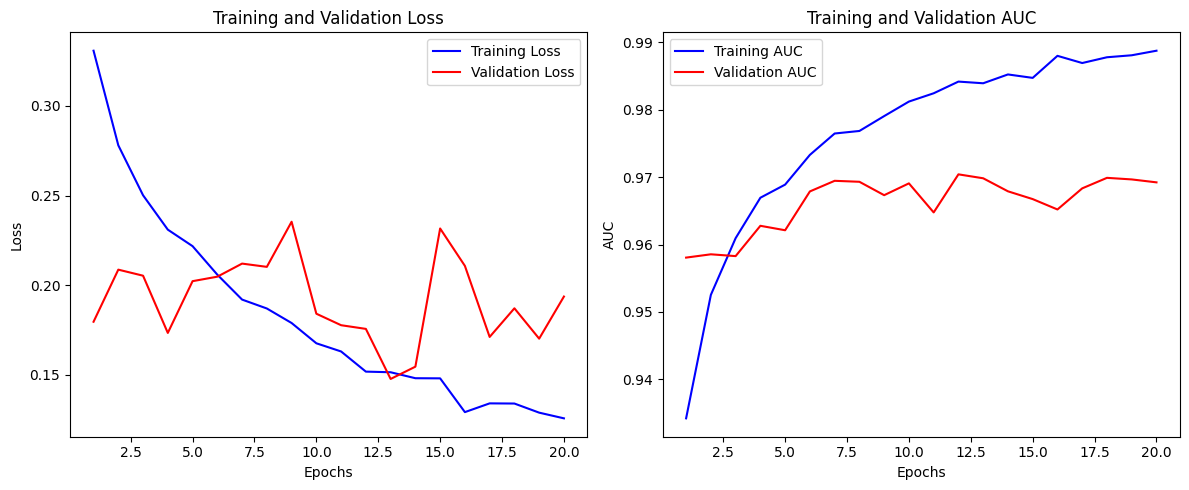

In [48]:
# Cell 9: Plot Training Results
plot_training_history(train_losses, val_losses, train_auc_scores, val_auc_scores)

Evaluating: 100%|██████████| 615/615 [00:15<00:00, 39.18it/s]


Test AUC: 0.9578


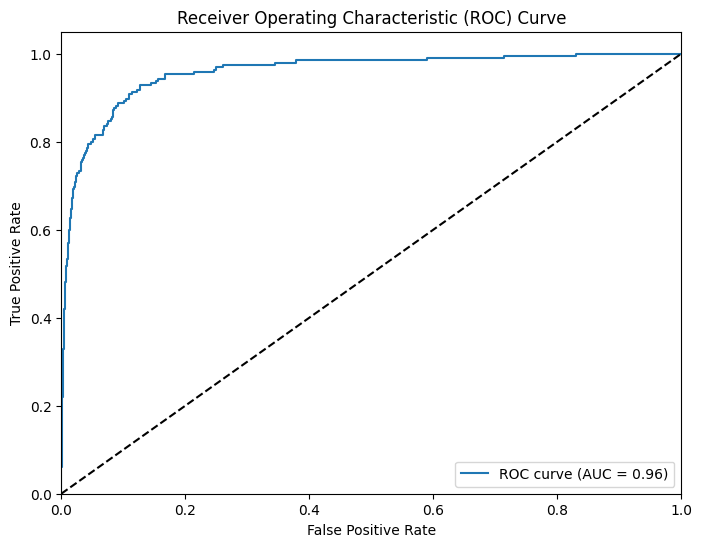

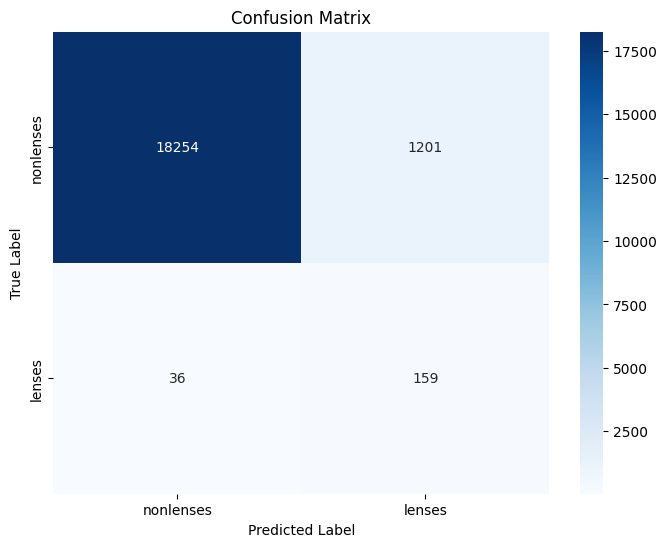

In [49]:
# Cell 10: Load Best Model and Evaluate on Test Set
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

def evaluate_model(model, data_loader, device):
    """Evaluates the model on the given data loader."""
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            labels = labels.unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()  # Sigmoid for probabilities

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    return all_labels, all_probs

test_labels, test_probs = evaluate_model(model, test_loader, DEVICE)

if len(test_labels) > 0:
    test_auc = roc_auc_score(test_labels, test_probs)
    print(f"Test AUC: {test_auc:.4f}")

    plot_roc_curve(test_labels, test_probs, num_classes=1)
    plot_confusion_matrix(
        test_labels, test_probs, classes=["nonlenses", "lenses"]
    )
else:
    print("Test AUC: N/A (empty test set)")